In [44]:
import pandas as pd
import jinja2
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Data preperation and knowledge

In [45]:
# read the csv file
match_data_unfiltered = pd.read_csv("preprocessed_dataframe_with_elo_mw_form_3.csv")
# match_data_unfiltered.to_excel("exel_test.xlsx")

In [46]:
# make FTR column to continous variable
def convert_ftr(result: str):
    if result == "D":
        return 1
    elif result == "H":
        return 2
    elif result == "A":
        return 0
    else: 
        return None
match_data_unfiltered['FTR'] = match_data_unfiltered['FTR'].apply(convert_ftr)

In [47]:
match_data_unfiltered = match_data_unfiltered.drop(["Unnamed: 0"], axis=1, errors="ignore")
# print(match_data_unfiltered.columns)
match_data_unfiltered.iloc[4589:4594].tail(n=5)

,index,Unnamed: 0.1,Unnamed: 0.1.1,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,QuotAttack,QuotDefend,DirectComparisonHG,DirectComparisonAG,B365Prediction,BetTrue,IWPrediction,BetTrueIW,DirectComparisonGoalDiff,DirectComparisonGoalQuot
4589,4589,4589,305,D1,22/05/2021,Wolfsburg,Mainz,2,3,0,...,1.154804,1.267976,2.0,0.0,H,False,H,False,2.0,inf
4590,4590,4590,0,D1,13/08/2021,M'gladbach,Bayern Munich,1,1,1,...,0.677409,1.498934,1.4,3.2,A,False,A,False,-1.8,0.437500
4591,4591,4591,1,D1,14/08/2021,Augsburg,Hoffenheim,0,4,0,...,0.286204,4.737221,1.6,2.6,A,True,A,True,-1.0,0.615385
4592,4592,4592,2,D1,14/08/2021,Bielefeld,Freiburg,0,0,1,...,0.335041,0.064789,0.8,1.5,A,False,A,False,-0.7,0.533333
4593,4593,4593,3,D1,14/08/2021,Stuttgart,Greuther Furth,5,1,2,...,2.563037,0.407930,1.1,1.2,H,True,H,True,-0.1,0.916667


In [48]:
# print correlation matrix
correlation_matrix_match_data_unfiltered = match_data_unfiltered.corr()[['FTR', 'FTHG', 'FTAG']]
correlation_matrix_match_data_unfiltered = correlation_matrix_match_data_unfiltered.dropna()
correlation_matrix_match_data_unfiltered = correlation_matrix_match_data_unfiltered.iloc[6:]
correlation_matrix_match_data_unfiltered.style.background_gradient()

,FTR,FTHG,FTAG
HTHG,0.425434,0.691083,-0.077238
HTAG,-0.439499,-0.066105,0.681759
HS,0.189774,0.282759,-0.110333
AS,-0.201513,-0.121474,0.297404
HST,0.354642,0.529431,-0.118181
AST,-0.369956,-0.122165,0.534106
HF,-0.043109,-0.110952,-0.010506
AF,0.004917,-0.079891,-0.051651
HC,-0.007333,0.024723,-0.042649
AC,-0.040962,-0.068897,0.063109


In [49]:
# filter for specific columns
# match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeElo", "AwayElo", "HomeAttack", "HomeDefend", "AwayAttack", "AwayDefend"]]
# "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    # "AwayAttackOld", "AwayDefendOld"
# print correlation matrix
match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeEloOld", "AwayEloOld", "DiffEloOld", "HomeAttackOld", "HomeDefendOld", "AwayAttackOld", "AwayDefendOld", "DiffDefendOld", "DiffAttackOld", "MarketValueDiff", "PDiff3Matches", 'PDiffAllMatches', 'DirectComparisonGoalDiff', 'DirectComparisonGoalQuot', 'DirectComparisonHG', 'DirectComparisonAG']]

correlation_matrix_match_data_reduced = match_data_reduced.corr()[['FTR', 'FTHG', 'FTAG']]
correlation_matrix_match_data_reduced.style.background_gradient()

,FTR,FTHG,FTAG
FTR,1.000000,0.632818,-0.652825
FTHG,0.632818,1.000000,-0.115890
FTAG,-0.652825,-0.115890,1.000000
HomeEloOld,0.100912,0.165829,-0.028317
AwayEloOld,-0.115695,-0.045695,0.149910
DiffEloOld,0.265837,0.259707,-0.218648
HomeAttackOld,0.175902,0.210148,-0.090111
HomeDefendOld,0.108135,0.099480,-0.068295
AwayAttackOld,-0.151120,-0.090360,0.168209
AwayDefendOld,-0.092621,-0.084673,0.084305


In [50]:
match_data_bl = match_data_unfiltered.copy(deep=True)
# match_data_bl = match_data_bl.dropna(subset=["PDiff3Matches"])
# match_data_unfiltered = match_data_unfiltered.dropna(subset=["PDiff10Matches"])

In [51]:
# X = match_data_unfiltered.loc[:, ["HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
#     "AwayAttackOld", "AwayDefendOld"
# ]]
features = ["DiffEloOld", "DiffAttackOld", "DiffDefendOld", "PDiff3Matches", "PDiff10Matches", "PQuotAllMatches", 
            "MarketValueDiff", "DirectComparisonHG", "DirectComparisonAG"]
#  "PDiff10Matches",
match_data_bl_wo_nan = match_data_bl.dropna(subset=features)
X = match_data_bl_wo_nan.loc[:, features]
# y = match_data_unfiltered.loc[:, ["FTHG", "FTAG"]]
y = match_data_bl_wo_nan.loc[:, ["FTR"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Train Decision Tree Classifier as first Model

In [52]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [53]:
clf.predict(X_test)

array([0, 2, 2, ..., 1, 1, 0], dtype=int64)

In [54]:
result = clf.score(X_test, y_test)

In [55]:
result

0.4014022787028922

In [56]:
class_names = {
    'Away'
    ,'Draw',
    'Home'
}
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'

## Ensemble Learning

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
from sklearn import linear_model

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
# X = match_data_unfiltered.loc[:, [
#     "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
#     "AwayAttackOld", "AwayDefendOld"
# ]]

# y = match_data_unfiltered.loc[:, ["FTR"]]

In [ ]:
match_data_unfiltered

,index,Unnamed: 0.1,Unnamed: 0.1.1,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,QuotAttack,QuotDefend,DirectComparisonHG,DirectComparisonAG,B365Prediction,BetTrue,IWPrediction,BetTrueIW,DirectComparisonGoalDiff,DirectComparisonGoalQuot
0,0,0,0,D1,11/08/06,Bayern Munich,Dortmund,2,0,2,...,2.215589,0.411358,NaN,NaN,H,True,H,True,NaN,NaN
1,1,1,1,D1,12/08/06,Hamburg,Bielefeld,1,1,1,...,0.982162,0.982162,NaN,NaN,H,False,H,False,NaN,NaN
2,2,2,2,D1,12/08/06,Leverkusen,Aachen,3,0,2,...,2.878939,0.324259,NaN,NaN,H,True,H,True,NaN,NaN
3,3,3,3,D1,12/08/06,Mainz,Bochum,2,1,2,...,1.401889,0.718342,NaN,NaN,H,True,H,True,NaN,NaN
4,4,4,4,D1,12/08/06,M'gladbach,Cottbus,2,0,2,...,2.215589,0.411358,NaN,NaN,H,True,H,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,4891,4891,301,D1,14/05/2022,Mainz,Ein Frankfurt,2,2,1,...,1.707233,1.191627,1.0,1.0,H,False,H,False,0.0,1.000000
4892,4892,4892,302,D1,14/05/2022,M'gladbach,Hoffenheim,5,1,2,...,2.032081,0.266797,1.6,1.4,H,True,H,True,0.2,1.142857
4893,4893,4893,303,D1,14/05/2022,Stuttgart,FC Koln,2,1,2,...,0.970749,0.803116,1.4,1.0,H,True,H,True,0.4,1.400000
4894,4894,4894,304,D1,14/05/2022,Union Berlin,Bochum,3,2,2,...,1.476492,0.532022,1.8,1.1,H,True,H,True,0.7,1.636364


In [ ]:
# X = match_data_bl.loc[:, ["DiffEloOld", "DiffAttackOld", "DiffDefendOld", "PDiff3Matches", "PDiffAllMatches", "MarketValueDiff"
# ]]
# X = X.dropna()
# #"PDiff10Matches",
# # y = match_data_unfiltered.loc[:, ["FTHG", "FTAG"]]
# y = match_data_bl.loc[:, ["FTR"]]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['lda'] = LinearDiscriminantAnalysis()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    return models

In [ ]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    scores = cross_val_score(model,
                             X,
                             y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise')
    return scores

>lr 0.510 (0.013)
>lda 0.505 (0.012)
>knn 0.423 (0.016)
>cart 0.398 (0.019)
>svm 0.504 (0.012)
>bayes 0.473 (0.015)


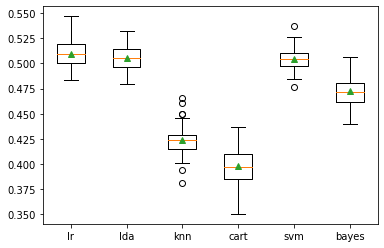

In [ ]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
X

,DiffEloOld,DiffAttackOld,DiffDefendOld,PDiff3Matches,PDiff10Matches,PQuotAllMatches,MarketValueDiff,DirectComparisonHG,DirectComparisonAG
90,10.206248,-0.790160,2.735138,3.0,2.0,1.166667,53.05,1.3,1.7
91,-18.300659,-0.044881,-2.152344,-6.0,-5.0,0.615385,-19.87,0.9,0.7
92,-34.677451,-2.431904,-0.756095,-5.0,-7.0,0.650000,-91.80,1.2,2.8
93,44.494676,2.776786,-0.139413,3.0,9.0,2.000000,-4.75,2.1,1.0
94,89.795027,1.876188,0.211856,3.0,10.0,2.428571,134.88,1.6,0.9
...,...,...,...,...,...,...,...,...,...
4891,5.106425,1.215809,-0.215011,4.0,1.0,1.097561,-130.75,1.0,1.0
4892,22.074235,-0.013209,2.041610,4.0,7.0,0.913043,92.35,1.6,1.4
4893,-27.347735,-0.913907,-0.445764,-4.0,-6.0,0.576923,92.97,1.4,1.0
4894,356.589890,0.812772,1.160533,1.0,7.0,1.285714,40.90,1.8,1.1


### Stack the single models to a combination

In [ ]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('lda', LinearDiscriminantAnalysis()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model


In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['lda'] = LinearDiscriminantAnalysis()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    return models


>lr 0.510 (0.013)
>lda 0.505 (0.012)
>knn 0.423 (0.016)
>cart 0.396 (0.018)
>svm 0.504 (0.012)
>bayes 0.473 (0.015)
>stacking 0.508 (0.014)


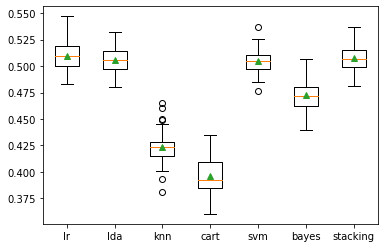

In [ ]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Neural Network

In [57]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical


In [58]:
# X = match_data_unfiltered.loc[:, [
#     "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
#     "AwayAttackOld", "AwayDefendOld"
# ]]

# y = match_data_unfiltered.loc[:, ["FTR"]]
# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=0.33,
#                                                     random_state=42)
# X_train = X
# y_train = y

print(X_train.shape)
print(X_test.shape)


(2315, 9)
(1141, 9)


In [59]:
y_train

,FTR
4689,2
3551,0
1968,1
1772,2
2632,0
...,...
1635,2
1670,2
1834,2
1220,1


In [60]:
def one_hot_encode_outputs(y_train, y_test):
    # one hot encode outputs
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    count_classes = y_test.shape[1]
    print(count_classes)
    return y_train, y_test

In [61]:
def train_model(X_train, y_train, number_of_epochs=20):
    model = Sequential()
    # model.add(Dense(500, activation='relu', input_dim=6))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(50, activation='relu'))
    # model.add(Dense(3, activation='softmax'))

    model.add(Dense(500, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    # build the model
    history = model.fit(X_train, y_train, epochs=number_of_epochs)
    return history, model

In [62]:
def print_accuracy(X_train, y_train, X_test, y_test, model):
    pred_train= model.predict(X_train)
    scores = model.evaluate(X_train, y_train, verbose=0)
    print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
    
    pred_test= model.predict(X_test)
    scores2 = model.evaluate(X_test, y_test, verbose=0)
    print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))  
    return pred_train, pred_test

In [63]:
def get_predictions(pred_test, y_test):
    # y_pred = [[1 if np.max(j)==i for i in j else 0] for j in pred_test]
    y_pred = []
    alpha = 0.05
    beta = 0.1
    for test in pred_test:
        # list_temp = []
        # for counter, j in enumerate(test):
        #     if np.max(test)==j:
        #         y_pred.append(counter)
        # print(test[1])
        if test[2] > test[1] and test[2] > test[0] and abs(test[2] - test[0]) > alpha:
            # if test[2] > test[1]+alpha and test[2] > test[0]:

            y_pred.append(2)
        elif test[0] > test[1] and abs(test[2] - test[0]) > alpha:
            y_pred.append(0)
        else:
            y_pred.append(1)
            #     list_temp.append(1)
            # else:
            #     list_temp.append(0)
        # y_pred.append(list_temp)
    y_pred
    y_test_res = []
    for test in y_test:
        # list_temp = []
        for counter, j in enumerate(test):
            if np.max(test)==j:
                y_test_res.append(counter)
    return y_test_res, y_pred

In [64]:
def print_confusion_matrix(y_test_res, y_pred):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cf = confusion_matrix(y_test_res, y_pred) #, labels=["Draw", "Home", "Away"])
    cfd = ConfusionMatrixDisplay(cf, display_labels=["Away", "Draw", "Home"])
    cfd.plot(cmap=plt.cm.Blues)

### test first NN with random data

3
Epoch 1/15
73/73 [==============================] - 1s 2ms/step - loss: 2.6559 - accuracy: 0.4143
Epoch 2/15
73/73 [==============================] - 0s 2ms/step - loss: 1.2791 - accuracy: 0.4222
Epoch 3/15
73/73 [==============================] - 0s 2ms/step - loss: 1.1835 - accuracy: 0.4366
Epoch 4/15
73/73 [==============================] - 0s 1ms/step - loss: 1.1825 - accuracy: 0.4617
Epoch 5/15
73/73 [==============================] - 0s 2ms/step - loss: 1.1097 - accuracy: 0.4745
Epoch 6/15
73/73 [==============================] - 0s 2ms/step - loss: 1.0718 - accuracy: 0.4796
Epoch 7/15
73/73 [==============================] - 0s 2ms/step - loss: 1.0705 - accuracy: 0.4791
Epoch 8/15
73/73 [==============================] - 0s 2ms/step - loss: 1.0527 - accuracy: 0.4852
Epoch 9/15
73/73 [==============================] - 0s 2ms/step - loss: 1.0390 - accuracy: 0.4982
Epoch 10/15
73/73 [==============================] - 0s 2ms/step - loss: 1.0445 - accuracy: 0.4843
Epoch 11/15
73/73

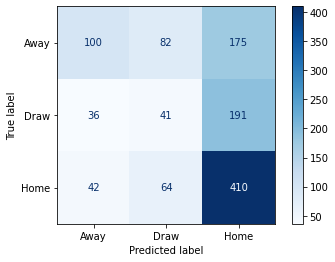

In [65]:
# learn model with random split for train test data
y_train, y_test = one_hot_encode_outputs(y_train, y_test)
trained_model_history, model = train_model(X_train, y_train, number_of_epochs=15)
pred_train, pred_test = print_accuracy(X_train, y_train, X_test, y_test, model)
y_test_res, y_pred = get_predictions(pred_test, y_test)
print_confusion_matrix(y_test_res, y_pred)

### test first NN with last season data

In [66]:
# split train test data to predict one season
# take the last 306 - 10*9 datapoints (because first 10 Matches are needed for the form)

X_train_s_2022, X_test_s_2022 = X.iloc[:-216], X.iloc[-216:]
y_train_s_2022, y_test_s_2022 = y[:-216], y[-216:]
match_data_bl_wo_nan_s_2022 = match_data_bl_wo_nan.iloc[-216:]

3
Epoch 1/15
102/102 [==============================] - 1s 2ms/step - loss: 2.7143 - accuracy: 0.4142
Epoch 2/15
102/102 [==============================] - 0s 2ms/step - loss: 1.3190 - accuracy: 0.4274
Epoch 3/15
102/102 [==============================] - 0s 2ms/step - loss: 1.3788 - accuracy: 0.4604
Epoch 4/15
102/102 [==============================] - 0s 2ms/step - loss: 1.1639 - accuracy: 0.4545
Epoch 5/15
102/102 [==============================] - 0s 2ms/step - loss: 1.1170 - accuracy: 0.4755
Epoch 6/15
102/102 [==============================] - 0s 2ms/step - loss: 1.2136 - accuracy: 0.4446
Epoch 7/15
102/102 [==============================] - 0s 1ms/step - loss: 1.0237 - accuracy: 0.5021
Epoch 8/15
102/102 [==============================] - 0s 1ms/step - loss: 1.0451 - accuracy: 0.4924
Epoch 9/15
102/102 [==============================] - 0s 1ms/step - loss: 1.0180 - accuracy: 0.5183
Epoch 10/15
102/102 [==============================] - 0s 1ms/step - loss: 1.0622 - accuracy: 0.49

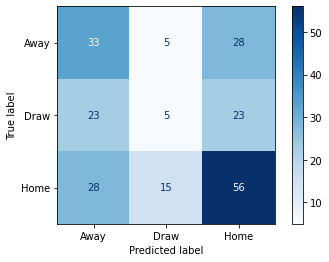

In [67]:
# train model and get results for one season predictions 
y_train_s_2022, y_test_s_2022 = one_hot_encode_outputs(y_train_s_2022, y_test_s_2022)
trained_model_history_s_2022, model_s_2022 = train_model(X_train_s_2022, y_train_s_2022, number_of_epochs=15)
pred_train_s_2022, pred_test_s_2022 = print_accuracy(X_train_s_2022, y_train_s_2022, X_test_s_2022, y_test_s_2022, model_s_2022)
y_test_res_s_2022, y_pred_s_2022 = get_predictions(pred_test_s_2022, y_test_s_2022)
print_confusion_matrix(y_test_res_s_2022, y_pred_s_2022)

In [68]:
# combine match data for season 22 with predictions for season 2022 for betting strategy

match_data_bl_wo_nan_s_2022.loc[:,'predictedResults'] = y_pred_s_2022
match_data_bl_wo_nan_s_2022

c:\Users\I539052\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\I539052\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,index,Unnamed: 0.1,Unnamed: 0.1.1,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,QuotDefend,DirectComparisonHG,DirectComparisonAG,B365Prediction,BetTrue,IWPrediction,BetTrueIW,DirectComparisonGoalDiff,DirectComparisonGoalQuot,predictedResults
4680,4680,4680,90,D1,05/11/2021,Mainz,M'gladbach,1,1,1,...,1.438142,1.2,2.20,A,False,A,False,-1.00,0.545455,0
4681,4681,4681,91,D1,06/11/2021,Bayern Munich,Freiburg,2,1,2,...,0.937499,2.2,1.20,H,True,H,True,1.00,1.833333,2
4682,4682,4682,92,D1,06/11/2021,Bochum,Hoffenheim,2,0,2,...,0.395446,1.5,1.75,A,False,A,False,-0.25,0.857143,0
4683,4683,4683,93,D1,06/11/2021,Stuttgart,Bielefeld,0,1,0,...,1.455523,0.8,1.80,H,False,H,False,-1.00,0.444444,2
4684,4684,4684,94,D1,06/11/2021,Wolfsburg,Augsburg,1,0,2,...,0.297315,2.4,0.40,H,True,H,True,2.00,6.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,4891,4891,301,D1,14/05/2022,Mainz,Ein Frankfurt,2,2,1,...,1.191627,1.0,1.00,H,False,H,False,0.00,1.000000,1
4892,4892,4892,302,D1,14/05/2022,M'gladbach,Hoffenheim,5,1,2,...,0.266797,1.6,1.40,H,True,H,True,0.20,1.142857,2
4893,4893,4893,303,D1,14/05/2022,Stuttgart,FC Koln,2,1,2,...,0.803116,1.4,1.00,H,True,H,True,0.40,1.400000,2
4894,4894,4894,304,D1,14/05/2022,Union Berlin,Bochum,3,2,2,...,0.532022,1.8,1.10,H,True,H,True,0.70,1.636364,2


In [69]:
df_season_2022_percentage_res = pd.DataFrame(pred_test_s_2022, columns=['ProbAwayWin', 'ProbDraw', 'ProbHomeWin'], index=match_data_bl_wo_nan_s_2022.index)
match_data_bl_wo_nan_s_2022.loc[:, ['ProbAwayWin', 'ProbDraw', 'ProbHomeWin']] = df_season_2022_percentage_res
match_data_bl_wo_nan_s_2022

c:\Users\I539052\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


,index,Unnamed: 0.1,Unnamed: 0.1.1,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,...,B365Prediction,BetTrue,IWPrediction,BetTrueIW,DirectComparisonGoalDiff,DirectComparisonGoalQuot,predictedResults,ProbAwayWin,ProbDraw,ProbHomeWin
4680,4680,4680,90,D1,05/11/2021,Mainz,M'gladbach,1,1,1,...,A,False,A,False,-1.00,0.545455,0,0.480737,0.287068,0.232195
4681,4681,4681,91,D1,06/11/2021,Bayern Munich,Freiburg,2,1,2,...,H,True,H,True,1.00,1.833333,2,0.017406,0.072747,0.909847
4682,4682,4682,92,D1,06/11/2021,Bochum,Hoffenheim,2,0,2,...,A,False,A,False,-0.25,0.857143,0,0.577001,0.282620,0.140379
4683,4683,4683,93,D1,06/11/2021,Stuttgart,Bielefeld,0,1,0,...,H,False,H,False,-1.00,0.444444,2,0.127279,0.419668,0.453053
4684,4684,4684,94,D1,06/11/2021,Wolfsburg,Augsburg,1,0,2,...,H,True,H,True,2.00,6.000000,2,0.163037,0.219623,0.617340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,4891,4891,301,D1,14/05/2022,Mainz,Ein Frankfurt,2,2,1,...,H,False,H,False,0.00,1.000000,1,0.419929,0.172108,0.407964
4892,4892,4892,302,D1,14/05/2022,M'gladbach,Hoffenheim,5,1,2,...,H,True,H,True,0.20,1.142857,2,0.215960,0.235188,0.548853
4893,4893,4893,303,D1,14/05/2022,Stuttgart,FC Koln,2,1,2,...,H,True,H,True,0.40,1.400000,2,0.236005,0.293266,0.470729
4894,4894,4894,304,D1,14/05/2022,Union Berlin,Bochum,3,2,2,...,H,True,H,True,0.70,1.636364,2,0.147645,0.285289,0.567065


In [70]:
match_data_bl_wo_nan_s_2022.to_csv("./match_data_bl_wo_nan_s_2022.csv")

In [71]:
df_season_2022_percentage_res

,ProbAwayWin,ProbDraw,ProbHomeWin
4680,0.480737,0.287068,0.232195
4681,0.017406,0.072747,0.909847
4682,0.577001,0.282620,0.140379
4683,0.127279,0.419668,0.453053
4684,0.163037,0.219623,0.617340
...,...,...,...
4891,0.419929,0.172108,0.407964
4892,0.215960,0.235188,0.548853
4893,0.236005,0.293266,0.470729
4894,0.147645,0.285289,0.567065


In [72]:
# class_names = {
#     'Away'
#     ,'Draw',
#     'Home'
# }
# # Plot non-normalized confusion matrix
# titles_options = [
#     ("Confusion matrix, without normalization", None),
#     ("Normalized confusion matrix", "true"),
# ]
# for title, normalize in titles_options:
#     disp = ConfusionMatrixDisplay.from_estimator(
# models['lr'],
#         X_test,
#         y_test,
#         #display_labels=class_names,
#         cmap=plt.cm.Blues,
#         normalize=normalize,
#     )
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)

# plt.show()

In [73]:
X

,DiffEloOld,DiffAttackOld,DiffDefendOld,PDiff3Matches,PDiff10Matches,PQuotAllMatches,MarketValueDiff,DirectComparisonHG,DirectComparisonAG
90,10.206248,-0.790160,2.735138,3.0,2.0,1.166667,53.05,1.3,1.7
91,-18.300659,-0.044881,-2.152344,-6.0,-5.0,0.615385,-19.87,0.9,0.7
92,-34.677451,-2.431904,-0.756095,-5.0,-7.0,0.650000,-91.80,1.2,2.8
93,44.494676,2.776786,-0.139413,3.0,9.0,2.000000,-4.75,2.1,1.0
94,89.795027,1.876188,0.211856,3.0,10.0,2.428571,134.88,1.6,0.9
...,...,...,...,...,...,...,...,...,...
4891,5.106425,1.215809,-0.215011,4.0,1.0,1.097561,-130.75,1.0,1.0
4892,22.074235,-0.013209,2.041610,4.0,7.0,0.913043,92.35,1.6,1.4
4893,-27.347735,-0.913907,-0.445764,-4.0,-6.0,0.576923,92.97,1.4,1.0
4894,356.589890,0.812772,1.160533,1.0,7.0,1.285714,40.90,1.8,1.1


## Train second NN

In [80]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend, callbacks
#create model
model = Sequential()

#get number of columns in training data
n_cols_2 = X.shape[1]
print(n_cols_2)
y = to_categorical(y)
#add layers to model
model.add(Dense(500, activation='sigmoid', input_dim=n_cols_2))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))

#compile model using accuracy to measure model performance
# model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], metrics=['accuracy'])
model.compile(metrics=['accuracy'], optimizer='rmsprop', 
              loss='categorical_crossentropy')
# K.set_value(model.optimizer.learning_rate, 0.01)

# early_stopping_monitor = EarlyStopping(patience=3)

# es = callbacks.EarlyStopping(monitor='val_loss', 
#                                    mode='min',
#                                    patience=10, 
#                                    restore_best_weights=True) 


history = model.fit(X, y,  epochs=20, validation_split=0.3) #, callbacks=[early_stopping_monitor]) #callbacks=[es],

Best: 0.291667 using {'neurons': 10}
0.291377 (0.024770) with: {'neurons': 1}
0.289931 (0.024378) with: {'neurons': 5}
0.291667 (0.024378) with: {'neurons': 10}
0.291088 (0.024678) with: {'neurons': 15}
0.290220 (0.023787) with: {'neurons': 20}
0.291088 (0.024205) with: {'neurons': 25}
0.291377 (0.023617) with: {'neurons': 30}


In [107]:
import keras_tuner as kt
from tensorflow import keras
from kerastuner.tuners import RandomSearch
# import tensorflow.keras import layers


def build_model(hp):
    model = keras.Sequential()
    # model.add(Dense(keras.layers.Flatten(input_dim=n_cols_2)))
    model.add(Dense(500, activation='sigmoid', input_dim=n_cols_2))
    for i in range(hp.Int('layers', 2, 6)):
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), 50, 100, step=10),
            activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=4,
    directory='my_dir',
    project_name='dat_exploration'
)

tuner.search_space_summary()

tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Trial 37 Complete [00h 00m 08s]
val_accuracy: 0.5256354212760925

Best val_accuracy So Far: 0.5289220213890076
Total elapsed time: 00h 03m 37s

Search: Running Trial #38

Value             |Best Value So Far |Hyperparameter
3                 |5                 |layers
80                |70                |units_0
sigmoid           |relu              |act_0
90                |60                |units_1
relu              |sigmoid           |act_1
70                |60                |units_2
sigmoid           |relu              |act_2
60                |50                |units_3
sigmoid           |sigmoid           |act_3
70                |60                |units_4
relu              |relu              |act_4
80                |80                |units_5
sigmoid           |relu              |act_5



Epoch 1/5
73/73 [==============================] - 1s 8ms/step - loss: 0.6152 - accuracy: 0.4704 - val_loss: 0.5909 - val_accuracy: 0.5206
Epoch 2/5
73/73 [==============================] - 0s 3ms/step - loss: 0.6008 - accuracy: 0.4946 - val_loss: 0.5876 - val_accuracy: 0.5188
Epoch 3/5
73/73 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.4942 - val_loss: 0.5840 - val_accuracy: 0.5241


UnknownError: Failed to rename: my_dir\dat_exploration\trial_37\checkpoint_temp/part-00000-of-00001.data-00000-of-00001 to: my_dir\dat_exploration\trial_37\checkpoint.data-00000-of-00001 : Access is denied.
; Input/output error [Op:MergeV2Checkpoints]

In [104]:
tuner.results_summary()

Results summary
Results in my_dir\dat_exploration
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 2
units_0: 100
act_0: sigmoid
units_1: 60
act_1: sigmoid
units_2: 50
act_2: sigmoid
units_3: 70
act_3: relu
units_4: 60
act_4: relu
units_5: 80
act_5: sigmoid
Score: 0.5284838080406189
Trial summary
Hyperparameters:
layers: 4
units_0: 80
act_0: relu
units_1: 60
act_1: relu
units_2: 90
act_2: sigmoid
units_3: 60
act_3: sigmoid
units_4: 60
act_4: relu
units_5: 60
act_5: relu
Score: 0.5258545279502869
Trial summary
Hyperparameters:
layers: 3
units_0: 100
act_0: sigmoid
units_1: 70
act_1: relu
units_2: 90
act_2: relu
units_3: 90
act_3: relu
units_4: 80
act_4: relu
units_5: 50
act_5: sigmoid
Score: 0.5249781012535095
Trial summary
Hyperparameters:
layers: 6
units_0: 50
act_0: sigmoid
units_1: 100
act_1: sigmoid
units_2: 50
act_2: relu
units_3: 50
act_3: relu
units_4: 50
act_4: relu
units_5: 50
act_5: relu
Score: 0.5197195410728455


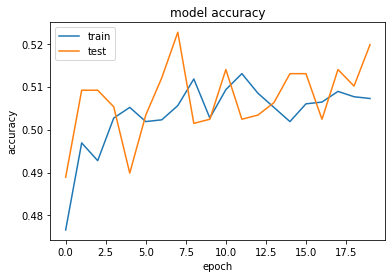

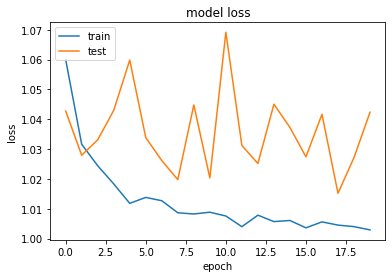

In [ ]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
models['lr']

NameError: name 'models' is not defined

In [ ]:
results

[array([0.50722543, 0.49927641, 0.52243126, 0.54703329, 0.48480463,
        0.51589595, 0.4934877 , 0.52387844, 0.5065123 , 0.51374819,
        0.49277457, 0.4934877 , 0.52243126, 0.49927641, 0.53111433,
        0.51300578, 0.50940666, 0.51085384, 0.51230101, 0.50940666,
        0.48554913, 0.52677279, 0.51808973, 0.49638205, 0.50940666,
        0.49855491, 0.52677279, 0.50940666, 0.50217077, 0.5195369 ,
        0.50867052, 0.50361795, 0.49782923, 0.52243126, 0.52098408,
        0.52745665, 0.5195369 , 0.50795948, 0.48335745, 0.50361795,
        0.49566474, 0.49638205, 0.51085384, 0.53111433, 0.51519537,
        0.51878613, 0.51085384, 0.50940666, 0.50940666, 0.49059334]),
 array([0.5       , 0.49493488, 0.51519537, 0.53256151, 0.48191027,
        0.50578035, 0.4934877 , 0.51664255, 0.50361795, 0.50217077,
        0.49277457, 0.50072359, 0.5065123 , 0.49493488, 0.52966715,
        0.51156069, 0.49638205, 0.51085384, 0.50361795, 0.50795948,
        0.47976879, 0.52532562, 0.52098408, 0.